# 基因演算法

此筆記本屬於 [AI for Beginners Curriculum](http://github.com/microsoft/ai-for-beginners)。


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## 一些理論

**遺傳算法**（Genetic Algorithms，簡稱 GA）基於**進化式方法**來解決人工智能問題，通過模擬種群的進化過程，尋找給定問題的最佳解決方案。這一方法由 [John Henry Holland](https://en.wikipedia.org/wiki/John_Henry_Holland) 在 1975 年提出。

遺傳算法基於以下概念：
* 問題的有效解可以表示為**基因**
* **交叉**允許我們將兩個解結合起來，生成新的有效解
* 通過某種**適應度函數**，使用**選擇**來挑選更優的解
* 引入**突變**以打破優化的穩定狀態，幫助跳出局部最小值

如果你想實現一個遺傳算法，你需要以下幾個步驟：

* 找到一種方法，使用**基因** $g\in\Gamma$ 來編碼問題的解
* 在基因集合 $\Gamma$ 上定義**適應度函數** $\mathrm{fit}: \Gamma\to\mathbb{R}$。函數值越小，解越優。
* 定義**交叉**機制，將兩個基因結合生成新的有效解 $\mathrm{crossover}: \Gamma^2\to\Gamma$。
* 定義**突變**機制 $\mathrm{mutate}: \Gamma\to\Gamma$。
在許多情況下，交叉和突變是相對簡單的算法，用於操作基因作為數字序列或位向量。

遺傳算法的具體實現可能因情況而異，但整體結構如下：

1. 選擇初始種群 $G\subset\Gamma$
2. 隨機選擇本步驟將執行的操作：交叉或突變
3. **交叉**：
   * 隨機選擇兩個基因 $g_1, g_2 \in G$
   * 計算交叉結果 $g=\mathrm{crossover}(g_1,g_2)$
   * 如果 $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ 或 $\mathrm{fit}(g)<\mathrm{fit}(g_2)$，用 $g$ 替換種群中的相應基因。
4. **突變** - 隨機選擇一個基因 $g\in G$，用 $\mathrm{mutate}(g)$ 替換它
5. 從第 2 步重複，直到我們獲得足夠小的 $\mathrm{fit}$ 值，或者達到步驟數的限制。

遺傳算法通常解決的任務包括：
1. 排程優化
1. 最優打包
1. 最優切割
1. 加速窮舉搜索


## 問題 1：公平的寶藏分配

**任務**：  
兩個人發現了一個寶藏，裡面有不同大小的鑽石（因此價格也不同）。他們需要將寶藏分成兩部分，使得價格的差距為 0（或最小化）。

**正式定義**：  
我們有一組數字 $S$。我們需要將其分成兩個子集 $S_1$ 和 $S_2$，使得  
$$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$  
並且滿足 $S_1\cup S_2=S$，$S_1\cap S_2=\emptyset$。

首先，讓我們定義集合 $S$：


In [3]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[8344 2197 9335 3131 5863 9429 3818 9791   15 5455 1396 9538 4872 6549
 8587 5986 6021 9764 8102 5083 5739 7684 8498 3007 6599  820 7490 2372
 9370 5235 3525 3154  859 1906 8159 3950 2173 2988 2050  349 8713 2284
 4177 6033 1651 9176 5049 8201  171 5081 1216 3756 4711 2757 7738 1272
 5650 6584 5395 9004 7797  969 8104 1283 1392 4001 5768  445  274  256
 8239 8015 4381 9021 1189 8879 1411 3539 6526 8011  136 7230 2332  451
 5702 2989 4320 2446 9578 8486 4027 2410 9588 8981 2177 1493 3232 9151
 4835 5594 6859 8394  369 3200  126 4259 2283 7755 2014 2458 8327 8082
 7413 7622 1206 5533 8751 3495 5868 8472 6850 3958 3149 4672 4810 6274
 4700 6134 4627 4616 6656 9949  884 2256 7419 1926 7973 5319 5967 9158
 3823 7697 9466 5675 5412 9784 5426 8209 3421 1136 6047 4429 8001 4417
 1381  722 7350 6018 6235 7860 5853 7660 5937 6242    1 9552 3971 8302
 2633 9227 7283  154 8599 4269 9392 8539 1630  368 2409 9351 3838 9814
 6186 5743 5083 1325 1610  779 3643 3262 5768 8725  961 4611 6310 4788
 1648 

讓我們用二進制向量 $B\in\{0,1\}^N$ 編碼問題的每個可能解，其中第 $i$ 個位置上的數字表示原集合 $S$ 中的第 $i$ 個數字屬於哪個集合（$S_1$ 或 $S_2$）。`generate` 函數將生成這些隨機二進制向量。


In [5]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0]


現在我們定義 `fit` 函數，用於計算解的「成本」。它將是兩個集合 $S_1$ 和 $S_2$ 的總和之間的差異：


In [6]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

133784

現在我們需要定義突變和交叉的函數：
* 對於突變，我們會隨機選擇一個位元並將其反轉（從 0 變成 1 或從 1 變成 0）
* 對於交叉，我們會從一個向量中取一些位元，然後從另一個向量中取一些位元。我們會使用相同的 `generate` 函數隨機選擇，哪些位元從哪個輸入遮罩中取出。


In [7]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

讓我們創建大小為 `pop_size` 的解的初始族群 $P$：


In [8]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

現在，執行進化的主要函數。`n` 是進化的步數。在每一步中：
* 以 30% 的機率執行突變，並用突變後的元素替換 `fit` 函數最差的元素
* 以 70% 的機率執行交叉

該函數返回最佳解（對應於最佳解的基因），以及每次迭代中族群內最小 `fit` 函數的歷史記錄。


In [9]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1] 4


你可以看到我們已經成功大幅縮減了 `fit` 函數！以下是顯示整個人口在過程中 `fit` 函數行為的圖表。


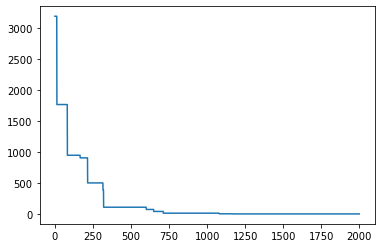

In [10]:
plt.plot(hist)
plt.show()

## 問題 2: N 皇后問題

**任務**：  
你需要在一個大小為 $N\times N$ 的棋盤上放置 $N$ 個皇后，並確保它們不會互相攻擊。

首先，我們不用遺傳算法來解決這個問題，而是使用全搜索的方法。我們可以用列表 $L$ 來表示棋盤的狀態，其中列表中的第 $i$ 個數字表示第 $i$ 行皇后所在的水平位置。很明顯，每個解法中每一行只會有一個皇后，並且每一行都會有一個皇后。

我們的目標是找到問題的第一個解，然後停止搜索。你可以輕鬆地擴展這個函數以生成所有可能的皇后擺放位置。


In [11]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

現在讓我們測量解決 20 皇后問題需要多長時間：


In [12]:
%timeit nqueens([],20,False)

10.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


現在讓我們用遺傳算法來解決同樣的問題。這個解法的靈感來自於[這篇博客文章](https://kushalvyas.github.io/gen_8Q.html)。

我們將用一個長度為 $N$ 的列表來表示每個解，並將攻擊彼此的皇后數量作為 `fit` 函數：


In [13]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

由於計算適應度函數非常耗時，我們將每個解與適應度函數的值一起存儲在族群中。讓我們生成初始族群：


In [14]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([2, 3, 8, 7, 5, 4, 1, 6]), 4),
 (array([3, 4, 5, 1, 2, 8, 6, 7]), 8),
 (array([1, 3, 7, 4, 5, 8, 6, 2]), 6),
 (array([1, 5, 4, 6, 8, 3, 7, 2]), 4),
 (array([3, 5, 7, 1, 8, 6, 4, 2]), 3)]

現在我們需要定義突變和交叉函數。交叉將通過在某個隨機點打斷兩個基因並將來自不同基因的兩部分連接在一起來結合它們。


In [15]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 2, 7, 8])

In [17]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

現在讓我們定義主要的進化循環。我們會將邏輯稍微改變一下，與之前的例子不同，目的是展示如何發揮創意。我們會持續循環，直到找到完美解決方案（適應度函數=0）。在每一步中，我們會取當前的世代，並生成相同大小的新世代。這是通過使用 `nxgeneration` 函數完成的，具體步驟如下：

1. 丟棄最不適合的解決方案 - 有一個 `discard_unfit` 函數可以做到這一點
2. 為世代添加一些隨機的解決方案
3. 生成大小為 `gen_size` 的新世代，對於每個新基因，執行以下步驟：
    - 隨機選擇兩個基因，選擇的概率與適應度函數成正比
    - 計算交叉
    - 以概率 `mutation_prob` 應用突變


In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([4, 7, 5, 3, 1, 6, 8, 2]), 0)

在大多數情況下，我們能夠很快找到解決方案，但在一些罕見的情況下，優化會陷入局部最小值，導致過程停滯很長時間。在測量平均時間時，考慮到這一點是很重要的：雖然在大多數情況下，遺傳算法比全面搜索更快，但在某些情況下可能需要更長的時間。為了解決這個問題，通常有必要限制要考慮的世代數量，如果我們無法找到解決方案，可以重新開始。


In [19]:
%timeit genetic(10)

The slowest run took 18.71 times longer than the fastest. This could mean that an intermediate result is being cached.
26.4 s ± 28.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



---

**免責聲明**：  
本文件已使用人工智能翻譯服務 [Co-op Translator](https://github.com/Azure/co-op-translator) 進行翻譯。儘管我們致力於提供準確的翻譯，但請注意，自動翻譯可能包含錯誤或不準確之處。原始語言的文件應被視為權威來源。對於重要信息，建議使用專業人工翻譯。我們對因使用此翻譯而引起的任何誤解或錯誤解釋概不負責。
